___
# Agenda
 - Numerical Optimization Techniques
  - Types of Optimization
  - Programming the Optimization
 - **Whirlwind Lecture Alert**
  - Entire classes cover these concepts in expanded form
  - But you are smart enough to get them in one lecture!
    - Because science!
    
___

# Last Time

|Description| Equations, Derivations, Hessian Calculations, and Miscellaneous|
|-----------|--------|
| Sigmoid Definition | $$ p(y^{(i)}=1\text{ | }\mathbf{x}^{(i)},\mathbf{w})=\frac{1}{1+\exp{(-\mathbf{w}^T \mathbf{x}^{(i)}})}$$ |
| Log Likelihood | $$ l(\mathbf{w}) = \sum_i \left( y^{(i)} \ln [g(\mathbf{w}^T \mathbf{x}^{(i)})] + (1-y^{(i)}) (\ln [1 - g(\mathbf{w}^T \mathbf{x}^{(i)})])  \right)  $$ |
| Vectorized Gradient | $$gradient =\sum_{i=1}^M (y^{(i)}-g(\mathbf{w}^T\mathbf{x}^{(i)}))\mathbf{x}^{(i)}$$ |
| Regularization | $$ \mathbf{w} \leftarrow \mathbf{w} + \eta \left[\underbrace{\nabla l(\mathbf{w})_{old}}_{\text{old gradient}} - C \cdot 2\mathbf{w} \right]$$|

___

<img src="PDF_slides/mark_scooter.png"  width="300">


# More Advanced  Optimization for Machine Learning
From previous notebooks, we know that the logistic regression update equation is given by:

$$ \underbrace{w_j}_{\text{new value}} \leftarrow \underbrace{w_j}_{\text{old value}} + \eta \underbrace{\left[\left(\sum_{i=1}^M (y^{(i)}-g(\mathbf{w}^T\mathbf{x}^{(i)}))x^{(i)}_j\right) - C \cdot 2w_j \right]}_{\nabla l(w)}$$

Which can be made into more generic notation by denoting the objective function as $l(\mathbf{w})$ and the gradient calculation as $\nabla$:
$$ \mathbf{w} \leftarrow \mathbf{w} + \eta \nabla l(\mathbf{w})$$

<img src="PDF_slides/batch.gif"  width="400">

One problem is that we still need to set the value of $\eta$, which can drastically change the performance of the optimization algorithm. If $\eta$ is too large, the algorithm might be unstable. If $\eta$ is too small, it might take a long time (i.e., many iterations) to converge.
$$ \mathbf{w} \leftarrow \mathbf{w} + \underbrace{\eta}_{\text{best step?}} \nabla l(\mathbf{w}) $$

We can solve this issue by performing a line search for the best value of $\eta$ along the direction of the gradient, as denoted by:

$$ \eta \leftarrow \arg\max_\eta \underbrace{\sum_{i=1}^M (y^{(i)}-g(\mathbf{w}^T\mathbf{x}^{(i)}))^2 -C\cdot\sum_j w_j^2}_{\nabla l(\mathbf{w})} $$

<img src="PDF_slides/line_search.gif"  width="400">

# Optimizing Logistic Regression via Line Search

In [1]:
from sklearn.datasets import load_iris
import numpy as np
from sklearn.metrics import accuracy_score
from scipy.special import expit

ds = load_iris()
X = ds.data
y = (ds.target>1).astype(np.int) # make problem binary

In [2]:
%%time
# from last time, our logistic regression algorithm is given by (including everything we previously had):
class BinaryLogisticRegression:
    def __init__(self, eta, iterations=20, C=0.001):
        self.eta = eta
        self.iters = iterations
        self.C = C
        # internally we will store the weights as self.w_ to keep with sklearn conventions
        
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'Binary Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained Binary Logistic Regression Object'
        
    # convenience, private:
    @staticmethod
    def _add_bias(X):
        return np.hstack((np.ones((X.shape[0],1)),X)) # add bias term
    
    @staticmethod
    def _sigmoid(theta):
        # increase stability, redefine sigmoid operation
        return expit(theta) #1/(1+np.exp(-theta))
    
    # vectorized gradient calculation with regularization using L2 Norm
    def _get_gradient(self,X,y):
        ydiff = y-self.predict_proba(X,add_bias=False).ravel() # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        
        gradient = gradient.reshape(self.w_.shape)
        gradient[1:] += -2 * self.w_[1:] * self.C
        
        return gradient
    
    # public:
    def predict_proba(self,X,add_bias=True):
        # add bias term if requested
        Xb = self._add_bias(X) if add_bias else X
        return self._sigmoid(Xb @ self.w_) # return the probability y=1
    
    def predict(self,X):
        return (self.predict_proba(X)>0.5) #return the actual prediction
    
    
    def fit(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        
        self.w_ = np.zeros((num_features,1)) # init weight vector to zeros
        
        # for as many as the max iterations
        for _ in range(self.iters):
            gradient = self._get_gradient(Xb,y)
            self.w_ += gradient*self.eta # multiply by learning rate 
            # add bacause maximizing 

blr = BinaryLogisticRegression(eta=0.1,iterations=500,C=0.001)

blr.fit(X,y)
print(blr)

yhat = blr.predict(X)
print('Accuracy of: ',accuracy_score(y,yhat))

Binary Logistic Regression Object with coefficients:
[[-0.81582596]
 [-1.49991076]
 [-1.34384503]
 [ 2.22988267]
 [ 1.92397039]]
Accuracy of:  0.98
CPU times: user 28.7 ms, sys: 3.16 ms, total: 31.9 ms
Wall time: 31.3 ms


In [3]:
%%time
# and we can update this to use a line search along the gradient like this:
from scipy.optimize import minimize_scalar
import copy
class LineSearchLogisticRegression(BinaryLogisticRegression):
    
    # define custom line search for problem
    
    @staticmethod
    def objective_function(eta,X,y,w,grad,C):
        wnew = w - grad*eta
        g = expit(X @ wnew)
        return -np.sum(np.log(g[y==1]))-np.sum(np.log(1-g[y==0])) + C*sum(wnew**2)
    
        
    def fit(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        
        self.w_ = np.zeros((num_features,1)) # init weight vector to zeros
        
        # for as many as the max iterations
        for _ in range(self.iters):
            gradient = -self._get_gradient(Xb,y)
            # minimization inopposite direction
            
            # do line search in gradient direction, using scipy function
            opts = {'maxiter':self.iters/50} # unclear exactly what this should be
            res = minimize_scalar(self.objective_function, # objective function to optimize
                                  bounds=(self.eta/1000,self.eta*10), #bounds to optimize
                                  args=(Xb,y,self.w_,gradient,self.C), # additional argument for objective function
                                  method='bounded', # bounded optimization for speed
                                  options=opts) # set max iterations
            
            eta = res.x # get optimal learning rate
            self.w_ -= gradient*eta # set new function values
            # subtract to minimize
                
            

lslr = LineSearchLogisticRegression(eta=0.1,iterations=400, C=0.001)

lslr.fit(X,y)

yhat = lslr.predict(X)
print(lslr)
print('Accuracy of: ',accuracy_score(y,yhat))         

Binary Logistic Regression Object with coefficients:
[[-1.67054237]
 [-2.16016901]
 [-1.94796417]
 [ 3.19460231]
 [ 3.12738014]]
Accuracy of:  0.98
CPU times: user 430 ms, sys: 5.95 ms, total: 436 ms
Wall time: 439 ms


This performs well, but was not too much faster than previously (this is because $\eta$ was chosen well in the initial example). 
___

# Self Test
<img src="PDF_slides/self_test_multiplies.png"  width="400">
_____

# Stochastic Gradient Descent
Sometimes the gradient calcualtion is too computational:
$$ \mathbf{w} \leftarrow \mathbf{w} + \eta\left( \sum_{i=1}^M (y^{(i)}-g(\mathbf{w}^T\mathbf{x}^{(i)}))\mathbf{x}^{(i)} -2C\cdot \mathbf{w}\right) $$

Instead, we can approximate the gradient using one instance, this is called stochastic gradient descent (SGD) because the steps can appear somewhat random.
$$ \mathbf{w} \leftarrow \mathbf{w} + \eta \underbrace{\left((y^{(i)}-g(\mathbf{w}^T\mathbf{x}^{(i)}))\mathbf{x}^{(i)}-2C\cdot \mathbf{w}\right)}_{\text{approx. gradient}} \text{,   where   } i\in M$$

<img src="PDF_slides/SGD.gif"  width="400">

Let's code up the SGD example.

In [4]:
%%time
class StochasticLogisticRegression(BinaryLogisticRegression):
    # stochastic gradient calculation 
    def _get_gradient(self,X,y):
        idx = int(np.random.rand()*len(y)) # grab random instance
        ydiff = y[idx]-self.predict_proba(X[idx],add_bias=False) # get y difference (now scalar)
        gradient = X[idx] * ydiff[:,np.newaxis] # make ydiff a column vector and multiply through
        
        gradient = gradient.reshape(self.w_.shape)
        gradient[1:] += -2 * self.w_[1:] * self.C
        
        return gradient
    
    
slr = StochasticLogisticRegression(0.05,500, C=0.001) # take a lot more steps!!

slr.fit(X,y)

yhat = slr.predict(X)
print(slr)
print('Accuracy of: ',accuracy_score(y,yhat))      

Binary Logistic Regression Object with coefficients:
[[-0.5750199 ]
 [-1.09073188]
 [-1.004314  ]
 [ 1.84374347]
 [ 1.52478477]]
Accuracy of:  0.8333333333333334
CPU times: user 14.7 ms, sys: 2.37 ms, total: 17.1 ms
Wall time: 15.6 ms


___

<img src="PDF_slides/BtJXjJcCAAE7QOB.jpg"  width="300">



# Optimizing with Second Order Derivatives
First, let's look at the one dimensional case when we have a function $l(w)$ where w is a scalar. The optimal value of w is given by:

$$ w \leftarrow w - \underbrace{[\frac{\partial^2}{\partial w}l(w)]^{-1}}_{\text{inverse 2nd deriv}}\underbrace{\frac{\partial}{\partial w}l(w)}_{\text{derivative}}  $$

Note that if $l(w)$ is a quadrativ function, this solution converges in a single step!


|Aside: an example with the second derivative:|
|------------------------------------------------------------------------|
|Say $l(w)=2w^2+4w+5$, and we want to minimize the function. We have that:
|$$\frac{\partial}{\partial w}l(w)=4w+4$$|
| $$\frac{\partial^2}{\partial w}l(w)=4$$|
|Therefore, if we choose $w_{start}=0$, we have:|
|$$\frac{\partial}{\partial w}l(0)=4$$  |
|$$\frac{\partial^2}{\partial w}l(0)=4$$ |
|So the update becomes|
|$$w \leftarrow w_{start} - \frac{1}{4}4 = -1$$|
|The solution is found in one step. This works for any initial value of $w_{start}$. Let's verify that the solution worked graphically.|

Text(-1, 2.5, '$\\leftarrow$found minimum')

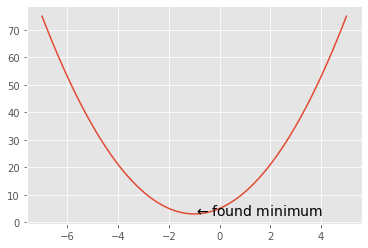

In [5]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

w = np.linspace(-7,5,100)
l = 2*w**2+4*w+5
plt.plot(w,l)
plt.text(-1,2.5,'$\leftarrow$found minimum',fontsize=14)

___

# Newton's Update Method
<img src="PDF_slides/newton.png"  width="600">

But how do we translate this over to objective funtions with more than one variable? We need a second derivative of a multivariate equation... enter, the hessian. Our new update is defined by Newton's method:

$$ w \leftarrow w - \underbrace{[\frac{\partial^2}{\partial w}l(w)]^{-1}}_{\text{inverse 2nd deriv}}\underbrace{\frac{\partial}{\partial w}l(w)}_{\text{derivative}}  $$

to

$$ \mathbf{w} \leftarrow \mathbf{w} + \eta \cdot \underbrace{\mathbf{H}[l(\mathbf{w})]^{-1}}_{\text{inverse Hessian}}\cdot\underbrace{\nabla l(\mathbf{w})}_{\text{gradient}}$$

where the Hessian is defined as follows for any multivariate equation $l(\mathbf{w})$:
$$ \nabla^2 l(\mathbf{w}) = \mathbf{H}[l(\mathbf{w})]   $$

$$  \mathbf{H}[l(\mathbf{w})] =  \begin{bmatrix}
        \frac{\partial^2}{\partial w_1}l(\mathbf{w}) &  \frac{\partial}{\partial w_1}\frac{\partial}{\partial w_2}l(\mathbf{w}) & \ldots     & \frac{\partial}{\partial w_1}\frac{\partial}{\partial w_N}l(\mathbf{w})  \\
        \frac{\partial}{\partial w_2}\frac{\partial}{\partial w_1}l(\mathbf{w})  & \frac{\partial^2}{\partial w_2}l(\mathbf{w}) &  \ldots     & \frac{\partial}{\partial w_2}\frac{\partial}{\partial w_N}l(\mathbf{w})  \\
        &  \vdots &\\
        \frac{\partial}{\partial w_N}\frac{\partial}{\partial w_1}l(\mathbf{w})  & \frac{\partial}{\partial w_N}\frac{\partial}{\partial w_2}l(\mathbf{w}) &  \ldots     & \frac{\partial^2}{\partial w_N}l(\mathbf{w}) \\
     \end{bmatrix}
$$



____
For logistic regression:

<img src="PDF_slides/hessian_derive.png"  width="400">

Therefore the Hessian for logistic regression becomes:
$$ \mathbf{H}_{j,k}[l(\mathbf{w})] = -\sum_{i=1}^M g(\mathbf{w}^T\mathbf{x}^{(i)})[1-g(\mathbf{w}^T\mathbf{x}^{(i)})]{x_k}^{(i)}{x_j}^{(i)} + \underbrace{2\cdot C}_{\text{regularization}}  $$

You can see the full derivation of the Hessian in my notes here:
- https://raw.githubusercontent.com/eclarson/MachineLearningNotebooks/master/PDF_Slides/HessianCalculation.pdf

$$ \mathbf{H}[l(\mathbf{w})] =  \mathbf{X}^T \cdot \text{diag}\left[g(\mathbf{X}\cdot\mathbf{w})*(1-g(\mathbf{X}\cdot\mathbf{w}))\right]\cdot \mathbf{X} -2C$$

Now we can place the Hessian derivation into the Newton Update Equation, like this:

$$ \mathbf{w} \leftarrow \mathbf{w} + \eta \cdot \underbrace{\mathbf{H}[l(\mathbf{w})]^{-1}}_{\text{inverse Hessian}}\cdot\underbrace{\nabla l(\mathbf{w})}_{\text{gradient}}$$

$$ \mathbf{w} \leftarrow \mathbf{w} + \eta \cdot \underbrace{\left[\mathbf{X}^T \cdot \text{diag}\left[g(\mathbf{X}\cdot\mathbf{w})(1-g(\mathbf{X}\cdot\mathbf{w}))\right] \cdot \mathbf{X} -2C \right]^{-1} }_{\text{inverse Hessian}} \cdot \underbrace{\mathbf{X}*y_{diff}}_{\text{gradient}}$$

So let's code this up using numpy:

In [6]:
%%time
from numpy.linalg import pinv
class HessianBinaryLogisticRegression(BinaryLogisticRegression):
    # just overwrite gradient function
    def _get_gradient(self,X,y):
        g = self.predict_proba(X,add_bias=False).ravel() # get sigmoid value for all classes
        hessian = X.T @ np.diag(g*(1-g)) @ X - 2 * self.C # calculate the hessian

        ydiff = y-g # get y difference
        gradient = np.sum(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        gradient = gradient.reshape(self.w_.shape)
        gradient[1:] += -2 * self.w_[1:] * self.C
        
        return pinv(hessian) @ gradient
       
hlr = HessianBinaryLogisticRegression(eta=1.0,iterations=4,C=0.001) # note that we need only a few iterations here

hlr.fit(X,y)
yhat = hlr.predict(X)
print(hlr)
print('Accuracy of: ',accuracy_score(y,yhat))

Binary Logistic Regression Object with coefficients:
[[-10.33521361]
 [ -1.11842524]
 [ -0.99722044]
 [  2.33435715]
 [  5.32207095]]
Accuracy of:  0.98
CPU times: user 13.5 ms, sys: 5.29 ms, total: 18.8 ms
Wall time: 13.4 ms


___
# Problems With the Hessian
Quadratic isn’t always a great assumption:
 - highly dependent on starting point
  - jumps can get really random!
 - near saddle points, inverse hessian unstable
 - hessian not always invertible… or invertible with correct numerical precision
 
The Hessian can sometimes be ill formed for these problems and can also be highly computational. Thus, we need to approximate the Hessian, and also use some heuristics (like momentum) to better control the steps we make and directions we use.  

## Quasi-Newton Methods
In general:
 - approximate the Hessian with something numerically sound and efficiently invertible 
 - back off to gradient descent when the approximate hessian is not stable
 - use momentum to update approximate hessian
 - A popular approach: use Broyden-Fletcher-Goldfarb-Shanno (BFGS)

### BFGS
One of the most popular quasi-Newton methods is known as Broyden-Fletcher-Goldfarb-Shanno (BFGS). We won't explicitly program the BFGS algorithm--instead we can take advantage of scipy's calculations to do it for us. For using this algorithm, we need to define the objective function and the gradient explicitly for another program to calculate. 

- https://en.wikipedia.org/wiki/Broyden–Fletcher–Goldfarb–Shanno_algorithm 

Essentially, we want to update the Hessian with an approximation that is easily invertible and based on stable gradient calculations. We can define the approximate Hessian for each iteration, $\mathbf{H}_k$. 

We build from the Secant Equation (exact for quadratic functions), that states:
$$ \mathbf{H}_k \mathbf{p}_k =  \mathbf{q}_k $$ 

where $ \mathbf{p}_k = \mathbf{w}_{k+1} - \mathbf{w}_k $ and $ \mathbf{q} = \nabla l(\mathbf{w}_{k+1}) - \nabla l(\mathbf{w}_k) $, the difference in the gradient.

We want the update of the Hessian to be approximated by the rank two update (two vectors multiplied):
$$ \mathbf{H}_{k+1}=\mathbf{H}_k+\mathbf{u}\cdot\mathbf{v}^T $$

Therefore we also want the updated Hessian to follow the secant formula:
$$ (\mathbf{H}_k +\mathbf{u}\cdot\mathbf{v}^T)\mathbf{p}_k = \mathbf{q}_k $$

By manipulating this equation, we can get a constraint for $\mathbf{u}$ as follows:
$$ \mathbf{u}_k = \frac{1}{\mathbf{v}_k^T\mathbf{p}_k}(\mathbf{q}_k-\mathbf{H}_k\mathbf{p}_k) $$

Because the Hessian needs to be symmetric we can then get an equation for $ \mathbf{v} $ as follows:
$$ \mathbf{v}_k = \mathbf{q}_k-\mathbf{H}_k\mathbf{p}_k $$ 
and
$$ \mathbf{H}_{k+1}=\mathbf{H}_k- \frac{\mathbf{v}_k\mathbf{v}_k^T}{\mathbf{v}_k^T\mathbf{p}_k} $$

Eventually, we need the inverse of $(\mathbf{H}_k+\mathbf{u}\cdot\mathbf{v}^T)^{-1}$, which luckily has a closed form solution according to the Sherman-Morrison formula:

$$ (\mathbf{A}+\mathbf{u}\cdot\mathbf{v}^T)^{-1} = \mathbf{A}^{-1} - \frac{\mathbf{A}^{-1} \mathbf{u} \mathbf{v}^T\mathbf{A}^{-1}}{\mathbf{v}^T \mathbf{A}^{-1} \mathbf{u}}  $$

Now we can add a momentum to the equation that "backs off" to a good approximation of the Hessian when the change in gradient is ill-formed. Placing it all together, we can get the following:


|Description| Equations, Derivations, Hessian Calculations, and Miscellaneous |
|-----------|--------|
|1. Initial Approx. Hessian for $k=0$ is identity matrix| $$\mathbf{H}_0=\mathbf{I}$$|
|2. Find update direction, $\mathbf{p}_k$ | $$ \mathbf{p}_k = -\mathbf{H}_k^{-1} \nabla l(\mathbf{w}_k) $$| 
|3. Update $w_k$|$$\mathbf{w}_{k+1}\leftarrow \mathbf{w}_k + \eta \cdot \mathbf{p}_k $$|
|4. Save scaled direction (from Secant)| $$\mathbf{s}_k=\eta \cdot \mathbf{p}_k$$ |
|5. Approximate change in derivative | $$\mathbf{v}_k = \nabla l(\mathbf{w}_{k+1}) - \nabla l(\mathbf{w}_k) $$|
|6. Redefine approx Hessian| $$\mathbf{H}_{k+1}=\mathbf{H}_k+\underbrace{\frac{\mathbf{v}_k \mathbf{v}_k^T}{\mathbf{v}_k^T \mathbf{s}_k}}_{\text{approx. Hessian}} -\underbrace{\frac{\mathbf{H}_k \mathbf{s}_k \mathbf{s}_k^T \mathbf{H}_k}{\mathbf{s}_k^T \mathbf{H}_k \mathbf{s}_k}}_{\text{momentum}} $$ |
|7. Approximate Inverse $\mathbf{H}_{k+1}^{-1}$ via Sherman Morris| $$ \mathbf{H}_{k+1}^{-1} = \mathbf{H}_{k}^{-1} + \frac{(\mathbf{s}_k^T \mathbf{v}_k+\mathbf{H}_{k}^{-1})(\mathbf{s}_k \mathbf{s}_k^T)}{(\mathbf{s}_k^T \mathbf{v}_k)^2}-\frac{\mathbf{H}_{k}^{-1} \mathbf{v}_k \mathbf{s}_k^T+\mathbf{s}_k \mathbf{v}_k^T\mathbf{H}_{k}^{-1}}{\mathbf{s}_k^T \mathbf{v}_k} $$|
| 8. Repeat starting at step 2| $$ k = k+1 $$| 

Of course, we do not need to program this method because it already exists. We just need to understand the API to get the full functionality. Recall that Logistic regression uses the following objective function:

$$ l(w) = \left(\sum_i y^{(i)} \ln g(x^{(i)}) + (1-y^{(i)})\ln[1-g(x^{(i)})]\right)  - C \cdot \sum_j w_j^2 $$

In [7]:
%%time
# for this, we won't perform our own BFGS implementation 
# (it takes a good deal of code and understanding of the algorithm)
# luckily for us, scipy has its own BFGS implementation:
from scipy.optimize import fmin_bfgs
class BFGSBinaryLogisticRegression(BinaryLogisticRegression):
    
    @staticmethod
    def objective_function(w,X,y,C):
        g = expit(X @ w)
        return -np.sum(np.log(g[y==1]))-np.sum(np.log(1-g[y==0])) + C*sum(w**2) #-np.sum(y*np.log(g)+(1-y)*np.log(1-g))

    @staticmethod
    def objective_gradient(w,X,y,C):
        g = expit(X @ w)
        ydiff = y-g # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0)
        gradient = gradient.reshape(w.shape)
        gradient[1:] += -2 * w[1:] * C
        return -gradient
    
    # just overwrite fit function
    def fit(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        
        self.w_ = fmin_bfgs(self.objective_function, # what to optimize
                            np.zeros((num_features,1)), # starting point
                            fprime=self.objective_gradient, # gradient function
                            args=(Xb,y,self.C), # extra args for gradient and objective function
                            gtol=1e-03, # stopping criteria for gradient, |v_k|
                            maxiter=self.iters, # stopping criteria iterations
                            disp=False)
        
        self.w_ = self.w_.reshape((num_features,1))
            
bfgslr = BFGSBinaryLogisticRegression(_,4,C=0.001) # note that we need only a few iterations here

bfgslr.fit(X,y)
yhat = bfgslr.predict(X)
print(bfgslr)
print('Accuracy of: ',accuracy_score(y,yhat))

Binary Logistic Regression Object with coefficients:
[[-0.30321484]
 [-0.69029206]
 [-0.87779373]
 [ 1.24988725]
 [ 0.79630503]]
Accuracy of:  0.9466666666666667
CPU times: user 8.59 ms, sys: 3.06 ms, total: 11.7 ms
Wall time: 12 ms


In [8]:
#str(bfgslr.eta)

### BFGS for Multiclass Logistic Regression
Now let's add BFGS to non-binary classification. As before, we will use one-versus-all.

In [9]:
class MultiClassLogisticRegression:
    def __init__(self, eta, iterations=20, C=0.0001):
        self.eta = eta
        self.iters = iterations
        self.C = C
        self.classifiers_ = []
        # internally we will store the weights as self.w_ to keep with sklearn conventions
    
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'MultiClass Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained MultiClass Logistic Regression Object'
        
    def fit(self,X,y):
        num_samples, num_features = X.shape
        self.unique_ = np.sort(np.unique(y)) # get each unique class value
        num_unique_classes = len(self.unique_)
        self.classifiers_ = []
        for i,yval in enumerate(self.unique_): # for each unique value
            y_binary = y==yval # create a binary problem
            # train the binary classifier for this class
            hblr = BFGSBinaryLogisticRegression(self.eta,self.iters,self.C)
            hblr.fit(X,y_binary)
            #print(accuracy(y_binary,hblr.predict(X)))
            # add the trained classifier to the list
            self.classifiers_.append(hblr)
            
        # save all the weights into one matrix, separate column for each class
        self.w_ = np.hstack([x.w_ for x in self.classifiers_]).T
        
    def predict_proba(self,X):
        probs = []
        for hblr in self.classifiers_:
            probs.append(hblr.predict_proba(X).reshape((len(X),1))) # get probability for each classifier
        
        return np.hstack(probs) # make into single matrix
    
    def predict(self,X):
        return np.argmax(self.predict_proba(X),axis=1) # take argmax along row
    



In [10]:
from sklearn.preprocessing import StandardScaler


ds = load_iris()
X = ds.data

X = StandardScaler().fit(X).transform(X)
y_not_binary = ds.target # note problem is NOT binary anymore, there are three classes!

In [11]:
%%time
lr = MultiClassLogisticRegression(_,iterations=10,C=0.001)
lr.fit(X,y_not_binary)
print(lr)

yhat = lr.predict(X)
print('Accuracy of: ',accuracy_score(y_not_binary,yhat))

MultiClass Logistic Regression Object with coefficients:
[[-2.09798658 -1.37396797  2.12955806 -2.32236253 -2.17109726]
 [-0.86615139  0.27565979 -1.49799306  0.37525711 -0.7357837 ]
 [-5.53176915  1.14249435  0.18753109  3.18851771  4.54893139]]
Accuracy of:  0.9333333333333333
CPU times: user 20.3 ms, sys: 3.78 ms, total: 24.1 ms
Wall time: 18.5 ms


In [12]:
%%time
# how do we compare now to sklearn?
from sklearn.linear_model import LogisticRegression

lr_sk = LogisticRegression(solver='lbfgs',n_jobs=1) # all params default
# note that sklearn is optimized for using the liblinear library with logistic regression
# ...and its faster than our implementation here

lr_sk.fit(X,y_not_binary) # no need to add bias term, sklearn does it internally!!
print(lr_sk.coef_)
yhat = lr_sk.predict(X)
print('Accuracy of: ',accuracy_score(y_not_binary,yhat))

[[-1.07404149  1.16006342 -1.93062866 -1.81168873]
 [ 0.58780051 -0.36182377 -0.36346274 -0.82619289]
 [ 0.48624098 -0.79823965  2.2940914   2.63788161]]
Accuracy of:  0.9733333333333334
CPU times: user 80.7 ms, sys: 17.6 ms, total: 98.3 ms
Wall time: 120 ms


In [13]:
%%time
# actually, we aren't quite as good as the lib linear implementation
# how do we compare now to sklearn?
from sklearn.linear_model import LogisticRegression

lr_sk = LogisticRegression(solver='liblinear',n_jobs=1) 

lr_sk.fit(X,y_not_binary) # no need to add bias term, sklearn does it internally!!
print(lr_sk.coef_)
yhat = lr_sk.predict(X)
print('Accuracy of: ',accuracy_score(y_not_binary,yhat))

[[-0.8105817   1.39940654 -1.68570483 -1.51199677]
 [ 0.1366492  -1.25852277  0.79123617 -0.91454276]
 [ 0.01209654 -0.14206705  1.8613731   2.69925398]]
Accuracy of:  0.9266666666666666
CPU times: user 3.87 ms, sys: 1.89 ms, total: 5.76 ms
Wall time: 5.1 ms


Liblinear is a great toolkit for linear modeling (from national Taiwan University) and the paper can be found here:
- https://www.csie.ntu.edu.tw/~cjlin/papers/liblinear.pdf

Actually, this solves a slightly different problem (than maximum likelihood) to make it extremely fast. **If you are a student taking this class for 7000 credit, you will need to slightly alter your method to get the same speed and result as sklearn.**

In [14]:
%%time
# its still faster! Can we fix that?
from joblib import Parallel, delayed

class ParallelMultiClassLogisticRegression(MultiClassLogisticRegression):
    @staticmethod
    def par_logistic(yval,eta,iters,C,X,y):
        y_binary = y==yval # create a binary problem
        # train the binary classifier for this class
        hblr = BFGSBinaryLogisticRegression(eta,iters,C)
        hblr.fit(X,y_binary)
        return hblr
    
    def fit(self,X,y):
        num_samples, num_features = X.shape
        self.unique_ = np.sort(np.unique(y)) # get each unique class value
        num_unique_classes = len(self.unique_)
        backend = 'threading' # can also try 'multiprocessing'
        
        self.classifiers_ = Parallel(n_jobs=-1,backend=backend)(
            delayed(self.par_logistic)(yval,self.eta,self.iters,self.C,X,y) for yval in self.unique_)
            
        # save all the weights into one matrix, separate column for each class
        self.w_ = np.hstack([x.w_ for x in self.classifiers_]).T
        
plr = ParallelMultiClassLogisticRegression(eta=0.1,iterations=10,C=0.0001)
plr.fit(X,y_not_binary)
print(plr)

yhat = plr.predict(X)
print('Accuracy of: ',accuracy_score(y_not_binary,yhat))

MultiClass Logistic Regression Object with coefficients:
[[-2.96339135 -1.87350042  3.03365343 -3.23850841 -3.02176564]
 [-0.86746125  0.29043763 -1.55156973  0.38672238 -0.78049004]
 [-7.05947198  1.56117499  0.41106483  4.06778601  5.81398125]]
Accuracy of:  0.94
CPU times: user 25.9 ms, sys: 8.55 ms, total: 34.4 ms
Wall time: 112 ms


___
Please note that the overhead of parallelization is not worth it for this problem!!

**When would it make sense???**
___



# Extended Logistic Regression Example

In this example we will explore methods of using logistic regression in scikit-learn. A basic understanding of scikit-learn is required to complete this notebook, but we start very basic. Note also that there are more efficient methods of separating testing and training data, but we will leave that for a later lecture.

First let's load a dataset and prepare it for analysis. We will use pandas to load in data, and then prepare it for classification. We will be using the titanic dataset (a very modest sized data set of about 1000 instances). The imputation methods used here are discussed in a previous notebook.
## Load Titanic Data


In [15]:
import pandas as pd
import numpy as np

df = pd.read_csv('data/titanic.csv') # read in the csv file

# 1. Remove attributes that just arent useful for us
del df['PassengerId']
del df['Name']
del df['Cabin']
del df['Ticket']

# 2. Impute some missing values, grouped by their Pclass and SibSp numbers
df_grouped = df.groupby(by=['Pclass','SibSp'])

# # now use this grouping to fill the data set in each group, then transform back
# fill in the numeric values
df_imputed = df_grouped.transform(lambda grp: grp.fillna(grp.median()))
# fill in the categorical values
df_imputed[['Sex','Embarked']] = df_grouped[['Sex','Embarked']].apply(lambda grp: grp.fillna(grp.mode()))
# fillin the grouped variables from original data frame
df_imputed[['Pclass','SibSp']] = df[['Pclass','SibSp']]

# 4. drop rows that still had missing values after grouped imputation
df_imputed.dropna(inplace=True)

# 5. Rearrange the columns
df_imputed = df_imputed[['Survived','Age','Sex','Parch','SibSp','Pclass','Fare','Embarked']]

df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 882 entries, 0 to 890
Data columns (total 8 columns):
Survived    882 non-null int64
Age         882 non-null float64
Sex         882 non-null object
Parch       882 non-null int64
SibSp       882 non-null int64
Pclass      882 non-null int64
Fare        882 non-null float64
Embarked    882 non-null object
dtypes: float64(2), int64(4), object(2)
memory usage: 62.0+ KB


In [16]:
# perform one-hot encoding of the categorical data "embarked"
tmp_df = pd.get_dummies(df_imputed.Embarked,prefix='Embarked')
df_imputed = pd.concat((df_imputed,tmp_df),axis=1) # add back into the dataframe

# replace the current Sex atribute with something slightly more intuitive and readable
df_imputed['IsMale'] = df_imputed.Sex=='male' 
df_imputed.IsMale = df_imputed.IsMale.astype(np.int)

# Now let's clean up the dataset
if 'Sex' in df_imputed:
    del df_imputed['Sex'] # if 'Sex' column still exists, delete it (as we created an ismale column)
    
if 'Embarked' in df_imputed:    
    del df_imputed['Embarked'] # get reid of the original category as it is now one-hot encoded
    
# Finally, let's create a new variable based on the number of family members
# traveling with the passenger

# notice that this new column did not exist before this line of code--we use the pandas 
#    syntax to add it in 
df_imputed['FamilySize'] = df_imputed.Parch + df_imputed.SibSp
df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 882 entries, 0 to 890
Data columns (total 11 columns):
Survived      882 non-null int64
Age           882 non-null float64
Parch         882 non-null int64
SibSp         882 non-null int64
Pclass        882 non-null int64
Fare          882 non-null float64
Embarked_C    882 non-null uint8
Embarked_Q    882 non-null uint8
Embarked_S    882 non-null uint8
IsMale        882 non-null int64
FamilySize    882 non-null int64
dtypes: float64(2), int64(6), uint8(3)
memory usage: 64.6 KB


## Training and Testing Split
For training and testing purposes, let's gather the data we have and grab 80% of the instances for training and the remaining 20% for testing. Moreover, let's repeat this process of separating the testing and training data three times. We will use the hold out cross validation method built into scikit-learn.

In [17]:
from sklearn.model_selection import ShuffleSplit

# we want to predict the X and y data as follows:
if 'Survived' in df_imputed:
    y = df_imputed['Survived'].values # get the labels we want
    del df_imputed['Survived'] # get rid of the class label
    norm_features = ['Age','Fare' ]
    df_imputed[norm_features] = (df_imputed[norm_features]-df_imputed[norm_features].mean()) / df_imputed[norm_features].std()
    X = df_imputed.to_numpy() # use everything else to predict!

    ## X and y are now numpy matrices, by calling 'values' on the pandas data frames we
    #    have converted them into simple matrices to use with scikit learn
    
    
# to use the cross validation object in scikit learn, we need to grab an instance
#    of the object and set it up. This object will be able to split our data into 
#    training and testing splits
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(
                         n_splits=num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)

ShuffleSplit(n_splits=3, random_state=None, test_size=0.2, train_size=None)


In [18]:
# run logistic regression and vary some parameters
from sklearn import metrics as mt

# first we create a reusable logisitic regression object
#   here we can setup the object with different learning parameters and constants
lr_clf = BFGSBinaryLogisticRegression(eta=0.1,iterations=10) # get object

# now we can use the cv_object that we setup before to iterate through the 
#    different training and testing sets. Each time we will reuse the logisitic regression 
#    object, but it gets trained on different data each time we use it.

iter_num=0
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in cv_object.split(X,y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    # train the reusable logisitc regression model on the training data
    lr_clf.fit(X_train,y_train)  # train object
    y_hat = lr_clf.predict(X_test) # get test set precitions

    # now let's get the accuracy and confusion matrix for this iterations of training/testing
    acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    print("====Iteration",iter_num," ====")
    print("accuracy", acc )
    print("confusion matrix\n",conf)
    iter_num+=1
    
# Also note that every time you run the above code
#   it randomly creates a new training and testing set, 
#   so accuracy will be different each time

====Iteration 0  ====
accuracy 0.7966101694915254
confusion matrix
 [[99 16]
 [20 42]]
====Iteration 1  ====
accuracy 0.7853107344632768
confusion matrix
 [[88 13]
 [25 51]]
====Iteration 2  ====
accuracy 0.807909604519774
confusion matrix
 [[95 14]
 [20 48]]


In [19]:
# this does the exact same thing as the above block of code, but with shorter syntax

for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X,y)):
    lr_clf.fit(X[train_indices],y[train_indices])  # train object
    y_hat = lr_clf.predict(X[test_indices]) # get test set precitions

    # print the accuracy and confusion matrix 
    print("====Iteration",iter_num," ====")
    print("accuracy", mt.accuracy_score(y[test_indices],y_hat)) 
    print("confusion matrix\n",mt.confusion_matrix(y[test_indices],y_hat))

====Iteration 0  ====
accuracy 0.8022598870056498
confusion matrix
 [[98 13]
 [22 44]]
====Iteration 1  ====
accuracy 0.7570621468926554
confusion matrix
 [[91 15]
 [28 43]]
====Iteration 2  ====
accuracy 0.7740112994350282
confusion matrix
 [[87 17]
 [23 50]]


## Interactive Example, adjusting C

In [20]:
from ipywidgets import widgets as wd

num_cv_iterations = 10
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.5)

def lr_explor(cost):
    print('Running')
    lr_clf = BFGSBinaryLogisticRegression(eta=0.1,iterations=10,
                                            C=float(cost)) # get object
    acc = []
    for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X,y)):
        lr_clf.fit(X[train_indices],y[train_indices])  # train object
        y_hat = lr_clf.predict(X[test_indices]) # get test set predictions
        acc.append(mt.accuracy_score(y[test_indices],y_hat))
        
    acc = np.array(acc)
    print(acc.mean(),'+-',2.7*acc.std())
        
wd.interact(lr_explor,cost=list(np.logspace(-4,1,15)),__manual=True)

interactive(children=(Dropdown(description='cost', options=(0.0001, 0.00022758459260747887, 0.0005179474679231…

<function __main__.lr_explor(cost)>

## Exhaustive Search for C, then Visualize with Boxplots

In [21]:
%%time

# alternatively, we can also graph out the values using boxplots
num_cv_iterations = 20
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.5)

def lr_explor(cost):
    lr_clf = BFGSBinaryLogisticRegression(eta=0.1,iterations=10,
                                            C=float(cost)) # get object
    acc = []
    for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X,y)):
        lr_clf.fit(X[train_indices],y[train_indices])  # train object
        y_hat = lr_clf.predict(X[test_indices]) # get test set predictions
        acc.append(mt.accuracy_score(y[test_indices],y_hat))
        
    acc = np.array(acc)
    return acc

costs = np.logspace(-5,1,20)
accs = []
for c in costs:
    accs.append(lr_explor(c))
    



CPU times: user 2.74 s, sys: 43.3 ms, total: 2.78 s
Wall time: 2.81 s


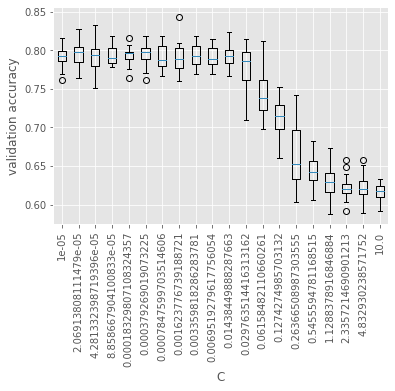

In [22]:
# now show a boxplot of the data across c
plt.boxplot(accs)
plt.xticks(range(1,len(costs)+1),costs,rotation='vertical')
plt.xlabel('C')
plt.ylabel('validation accuracy')
plt.show()


___
# Next Time: Neural Networks
___

In this notebook you learned:
- Formulation of Logistic regression with different optimization strategies
 - Line Search
 - Mini-batch
 - Stochastic Gradient
- Newton's Approach using Hessian 
- Quasi Newton's Method
- Use Exhaustive Searches for Finding "C" 
- And Training/Testing Splits